In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import jaccard_similarity_score
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

%matplotlib inline

In [2]:
df_features = pd.read_csv('trainingSet/features_training_2.5.scv', sep=' ')
df_labels = pd.read_csv('trainingSet/labels_training_2.5.scv', sep=' ')

In [3]:
X_train, Y_train = df_features[df_features.columns[:len(df_features.columns)-1]].values, np.squeeze(df_labels.values)
X_train.shape

(3697, 11765)

In [18]:
def svr_scale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def svr_preprocess(X):
    return [list(svr_scale(x[:5])) + list(x[5:]) for x in X]

In [19]:
X = svr_preprocess(X_train)

### Models

In [6]:
kr_model = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)}, scoring='mean_squared_error', n_jobs=4)
kr_model.fit(kr_X, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
      kernel_params=None),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'alpha': [1.0, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [ ]:
svr_model = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}, scoring='mean_squared_error', n_jobs=4)
svr_model.fit(X, Y_train)

In [11]:
lasso_model = LassoCV(cv=5).fit(svr_X, Y_train)

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [12]:
enet_model = ElasticNetCV(cv=5, l1_ratio=.5).fit(svr_X, Y_train)

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [7]:
kr_model.best_score_

-3.6857835559531531

In [10]:
svr_accuracy = [mean_score for _, mean_score, _ in svr_model.grid_scores_]
svr_model.best_score_

-3.7281917103288635

In [ ]:
linear_ridge_model = RidgeCV()

In [80]:
linear_svr_model = GridSearchCV(LinearSVR(), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "epsilon": [1e0, 1e-1, 1e-2, 1e-3, 1e-4]}, scoring='mean_squared_error', n_jobs=4)
linear_svr_model.fit(svr_X, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': [1.0, 10.0, 100.0, 1000.0], 'epsilon': [1.0, 0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [81]:
linear_svr_model.best_score_

-3.9632393747795298

### Jaccard index

Lasso, Elastic Net

In [27]:
def get_not_nul_indexes(value_list):
    return [i for i, x in enumerate(value_list) if x != 0]

def concat(Arr1, Arr2):
    return np.array(list(Arr1) + list(Arr2))

def cross_validation_for_weights(clf, X, y, scoring, cv_fold = 5):
    scores = []
    weights = []
    n = len(X) // cv_fold
    for i in range(cv_fold):
        if i == 0:
            clf.fit(X[n:], y[n:])
        elif i == cv_fold - 1:
             clf.fit(X[:i*n], y[:i*n])
        else:
            clf.fit(concat(X[:i*n], X[(i+1)*n:]), concat(y[:i*n], y[(i+1)*n:]))
        y_predict = clf.predict(X[i*n:(i+1)*n])
        y_true = y[i*n:(i+1)*n]
        weights.append(clf.coef_)
    indexes_list = list(map(get_not_nul_indexes, weights))
    coefs_count_list = list(map(len, weights))
    for i in range(cv_fold):
        for j in range(cv_fold):
            if i != j:
                res = scoring(indexes_list[i], indexes_list[j])
                if res:
                    scores.append(res)
    return scores, coefs_count_list

In [28]:
def jaccard_index_score(x1, x2):
    set_1 = set(x1)
    set_2 = set(x2)
    n = len(set_1.intersection(set_2))
    union_size = float(len(set_1) + len(set_2) - n)
    if union_size != 0 :
        return n / union_size
    else: return None

In [29]:
lasso_alphas = lasso_model.alphas_
lasso_jaccard_and_count_list = []

for alpha in lasso_alphas:
    lasso_jaccard_and_count_list.append(cross_validation_for_weights(Lasso(alpha=alpha), svr_X, Y_train, scoring=jaccard_index_score))

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [30]:
alphas = enet_model.alphas_
enet_jaccard_and_count_list = []

for alpha in alphas:
    enet_jaccard_and_count_list.append(cross_validation_for_weights(ElasticNet(alpha=alpha, l1_ratio=0.5), svr_X, Y_train, scoring=jaccard_index_score))

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [82]:
linear_svr_params = {"C": [1e0, 1e1, 1e2, 1e3],
                               "epsilon": [1e0, 1e-1, 1e-2, 1e-3, 1e-4]}
linear_svr_jaccard_and_count_list = []

for C in linear_svr_params["C"]:
    for epsilon in linear_svr_params["epsilon"]:
        linear_svr_jaccard_and_count_list.append(cross_validation_for_weights(LinearSVR(C=C, epsilon=epsilon), svr_X, Y_train, scoring=jaccard_index_score))

In [83]:
lasso_jaccard_index_list = [x for x, y in lasso_jaccard_and_count_list]
enet_jaccard_index_list = [x for x, y in enet_jaccard_and_count_list]
lasso_features_count_list = [y for x, y in lasso_jaccard_and_count_list]
enet_features_count_list = [y for x, y in enet_jaccard_and_count_list]
linear_svr_jaccard_index_list = [x for x, y in linear_svr_jaccard_and_count_list]
linear_svr_features_count_list = [y for x, y in linear_svr_jaccard_and_count_list]

In [84]:
lasso_stability = [np.mean(line) for line in lasso_jaccard_index_list]
enet_stability = [np.mean(line) for line in enet_jaccard_index_list]
lasso_complexity = np.mean(lasso_features_count_list, axis=1)
enet_complexity = np.mean(enet_features_count_list, axis=1)
linear_svr_stability = [np.mean(line) for line in linear_svr_jaccard_index_list]
linear_svr_complexity = np.mean(linear_svr_features_count_list, axis=1)

In [34]:
l1 = enet_jaccard_index_list
l2 = lasso_jaccard_index_list
enet_alphas = enet_model.alphas_
lasso_alphas = lasso_model.alphas_
l1_mean = [np.mean(line) for line in l1]
l2_mean = [np.mean(line) for line in l2]
l1_std = [np.std(line) for line in l1]
l2_std = [np.std(line) for line in l2]

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


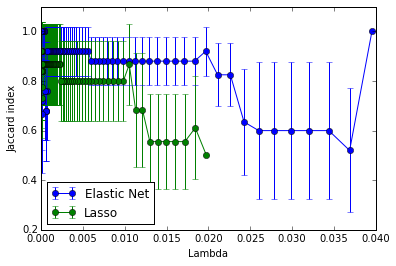

In [41]:
lambda_count = 0
plt.figure()
plt.errorbar(enet_alphas[lambda_count:], l1_mean[lambda_count:], yerr=l1_std[lambda_count:], fmt='-o', label="Elastic Net")
plt.errorbar(lasso_alphas[lambda_count:], l2_mean[lambda_count:], yerr=l2_std[lambda_count:], fmt='-o', label="Lasso")
plt.xlabel("Lambda")
plt.ylabel("Jaccard index")
plt.legend(loc="best")
plt.savefig("lasso_enet_jaccard.eps", format="eps")
plt.show()

In [44]:
def cross_validation_for_features_number(clf, X, y, cv_fold=10):
    features_number_list = []
    n = len(X) // cv_fold
    for i in range(cv_fold):
        if i == 0:
            clf.fit(X[n:], y[n:])
        elif i  == cv_fold - 1:
             clf.fit(X[:i*n], y[:i*n])
        else:
            clf.fit(concat(X[:i*n], X[(i+1)*n:]), concat(y[:i*n], y[(i+1)*n:]))
        y_predict = clf.predict(X[i*n:(i+1)*n])
        y_true = y[i*n:(i+1)*n]
        features_number_list.append(len(get_not_nul_indexes(clf.coef_)))
    return int(np.mean(features_number_list))

In [45]:
lasso_alphas = lasso_model.alphas_
features_number_list = [cross_validation_for_features_number(Lasso(alpha=alpha), svr_X, Y_train)\
                            for alpha in alphas]

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [46]:
enet_alphas = enet_model.alphas_
enet_features_number_list = [cross_validation_for_features_number(ElasticNet(alpha=alpha, l1_ratio=0.5), svr_X, Y_train)\
                            for alpha in alphas]

/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


/Users/luba_yaronskaya/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


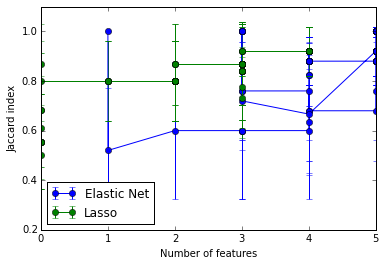

In [47]:
deleted = -1
plt.figure()
plt.errorbar(enet_features_number_list[:deleted], l1_mean[:deleted], yerr=l1_std[:deleted], fmt='-o', label="Elastic Net")
plt.errorbar(features_number_list[:deleted], l2_mean[:deleted], yerr=l2_std[:deleted], fmt='-o', label="Lasso")
plt.xlabel("Number of features")
plt.ylabel("Jaccard index")
plt.legend(loc="best")
plt.savefig("lasso_enet_jaccard_features_all.eps", format="eps")
plt.show()

In [ ]:
ridge_alphas = lasso_alphas

SVR Jaccard

In [ ]:
import sys
from itertools import *
from multiprocessing.pool import Pool
from multiprocessing import cpu_count

In [50]:
def jaccard_index_score(x1, x2):
    set_1 = set(x1)
    set_2 = set(x2)
    n = len(set_1.intersection(set_2))
    union_size = float(len(set_1) + len(set_2) - n)
    if union_size != 0 :
        return n / union_size
    else: return None

def concat(Arr1, Arr2):
    return np.array(list(Arr1) + list(Arr2))

def cross_validation_for_sv(args):
    cv_fold = 5
    X, y, clf = args
    scores = []
    sv_indexes_list = []
    n = len(X) // cv_fold
    for i in range(cv_fold):
        if i == 0:
            clf.fit(X[n:], y[n:])
        elif i  == cv_fold - 1:
             clf.fit(X[:i*n], y[:i*n])
        else:
            clf.fit(concat(X[:i*n], X[(i+1)*n:]), concat(y[:i*n], y[(i+1)*n:]))
        sv_indexes_list.append(clf.support_)
    coefs_count_list = list(map(len, sv_indexes_list))
    for i in range(cv_fold):
        for j in range(cv_fold):
            if i != j:
                res = jaccard_index_score(sv_indexes_list[i], sv_indexes_list[j])
                if res:
                    scores.append(res)
    return scores, coefs_count_list

In [51]:
clfs = [SVR(kernel='rbf', C=c, gamma=gamma) for c in [1e0, 1e1, 1e2, 1e3] for gamma in np.logspace(-2, 2, 5)]
star = [(svr_X, Y_train, clf) for clf in clfs]
svr_mean_similarities_and_count_list = list(map(cross_validation_for_sv, star))

In [53]:
svr_jaccard_list = [x for x, y in svr_mean_similarities_and_count_list]
svr_sv_count_list = [y for x, y in svr_mean_similarities_and_count_list]

In [55]:
svr_stability = [np.mean(line) for line in svr_jaccard_list]
svr_complexity = np.mean(svr_sv_count_list, axis=1)

In [ ]:
processes = cpu_count() - 1
pool = Pool(processes)
clfs = [SVR(kernel='rbf', C=c, gamma=gamma) for c in [1e0, 1e1, 1e2, 1e3] for gamma in np.logspace(-2, 2, 5)]]
star = [(X, y, clf) for clf in clfs]
svr_mean_similarities_and_count_list = pool.map(cross_validation_for_sv, star)

### Complexity

In [ ]:
kr_complexity = []
for alpha in [1e0, 0.1, 1e-2, 1e-3]:
    for gamma in np.logspace(-2, 2, 5):
        kr_complexity.append(cross_validation_for_kr_coefs(X, y,KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha))

In [ ]:
def concat(Arr1, Arr2):
    return np.array(list(Arr1) + list(Arr2))

def cross_validation_for_weights_count(args):
    cv_fold = 5
    X, y, clf = args
    sv_counts = []
    weights = []
    n = len(X) / cv_fold
    for i in range(cv_fold):
        if i == 0:
            clf.fit(X[n:], y[n:])
        elif i  == cv_fold - 1:
             clf.fit(X[:i*n], y[:i*n])
        else:
            clf.fit(concat(X[:i*n], X[(i+1)*n:]), concat(y[:i*n], y[(i+1)*n:]))
        y_predict = clf.predict(X[i*n:(i+1)*n])
        y_true = y[i*n:(i+1)*n]
        weights.append(clf.coef_)
    indexes_list = map(get_not_nul_indexes, weights)
    sv_counts = map(len, indexes_list)
    return int(np.mean(sv_counts))

In [ ]:
lasso_alphas = lasso_model.alphas_
lasso_features_count_list = []

for alpha in lasso_alphas:
    lasso_features_count_list.append(cross_validation_for_weights_count((X, y, Lasso(alpha=alpha))))

In [ ]:
enet_alphas = lasso_model.alphas_
enet_features_count_list = []

for alpha in enet_alphas:
    enet_features_count_list.append(cross_validation_for_weights_count((X, y, ElasticNet(alpha=alpha, l1_ratio=0.5))))

### Accuracy

In [112]:
kr_accuracy = [mean_score for _, mean_score, _ in kr_model.grid_scores_]
svr_accuracy = [mean_score for _, mean_score, _ in svr_model.grid_scores_]
linear_svr_accuracy = [mean_score for _, mean_score, _ in linear_svr_model.grid_scores_]

In [113]:
def minus(x):
    return [-a for a in x]

In [114]:
svr_accuracy = minus(svr_accuracy)
kr_accuracy = minus(kr_accuracy)
linear_svr_accuracy = minus(linear_svr_accuracy)

In [25]:
def accuracy(linear_model):
    return np.mean(linear_model.mse_path_, axis=1)

In [88]:
lasso_accuracy = accuracy(lasso_model)
enet_accuracy = accuracy(enet_model)

### Train size

In [98]:
svr = svr_model.best_estimator_
kr = kr_model.best_estimator_
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, svr_X, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="mean_squared_error", cv=5)
train_sizes_kr, train_scores_kr, test_scores_kr = \
    learning_curve(kr, kr_X, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="mean_squared_error", cv=5)

In [90]:
linear_svr = linear_svr_model.best_estimator_
train_sizes_linear_svr, train_scores_linear_svr, test_scores_linear_svr = \
    learning_curve(linear_svr, svr_X, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="mean_squared_error", cv=5)

In [99]:
kernel_svr_score = -test_scores_svr.mean(axis=1)
kernel_ridge_score = -test_scores_kr.mean(axis=1)
linear_svr_score = -test_scores_linear_svr.mean(axis=1)

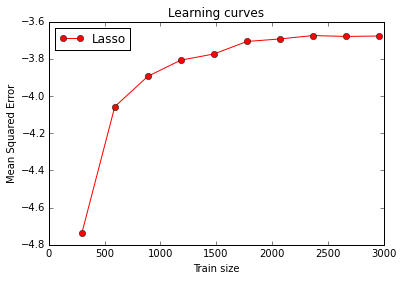

In [18]:
lasso_estimator = Lasso(alpha = 0.0001)
train_sizes, train_scores, test_scores = \
    learning_curve(lasso_estimator, X_train_5, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="mean_squared_error", cv=5)
lasso_score = -test_scores.mean(1)

plt.figure()
plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="Lasso")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

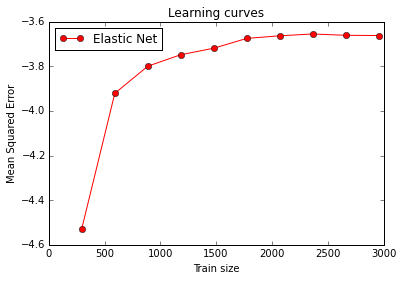

In [19]:
enet_estimator = ElasticNet(alpha=10**-2, l1_ratio=0.5)
train_sizes, train_scores, test_scores = \
    learning_curve(enet_estimator, X_train_5, Y_train, train_sizes=np.linspace(0.1, 1, 10),
                   scoring="mean_squared_error", cv=5)
enet_score = -test_scores.mean(1)

plt.figure()
plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="Elastic Net")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

### Немного графиков

(1.7039476854742892,
 4.7039476854742892,
 3.6533207971118813,
 4.0979682225084737)

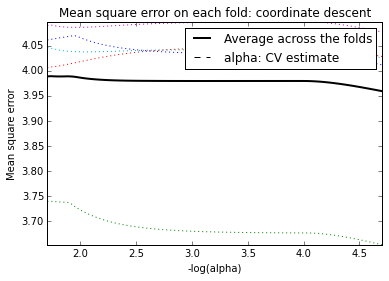

In [16]:
m_log_alphas = -np.log10(lasso_model.alphas_)

plt.figure()
plt.plot(m_log_alphas, lasso_model.mse_path_, ':')
plt.plot(m_log_alphas, lasso_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')

(1.402917689810308, 4.402917689810308, 3.6748646975969388, 4.0979363083722316)

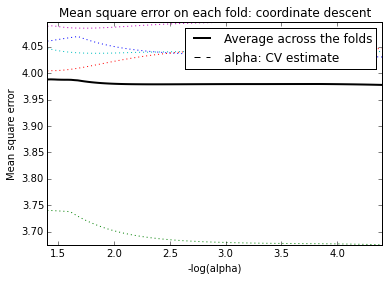

In [17]:
m_log_alphas = -np.log10(enet_model.alphas_)

plt.figure()
plt.plot(m_log_alphas, enet_model.mse_path_, ':')
plt.plot(m_log_alphas, enet_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(enet_model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')

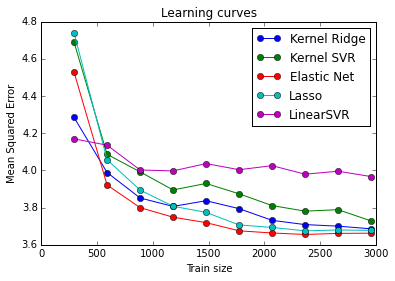

In [100]:
plt.figure()
# plt.plot(train_sizes, linear_ridge_score, 'o-',
#          label="Linear Ridge")
plt.plot(train_sizes, kernel_ridge_score, 'o-',
         label="Kernel Ridge")
plt.plot(train_sizes, kernel_svr_score, 'o-', 
         label="Kernel SVR")
plt.plot(train_sizes, enet_score, 'o-', 
         label="Elastic Net")
plt.plot(train_sizes, lasso_score, 'o-',
         label="Lasso")
plt.plot(train_sizes, linear_svr_score, 'o-',
         label="LinearSVR")
# plt.plot(train_sizes, rf_score, 'o-',
#          label="Random Forest")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")
plt.savefig("plots_simple.eps", format="eps")
plt.show()

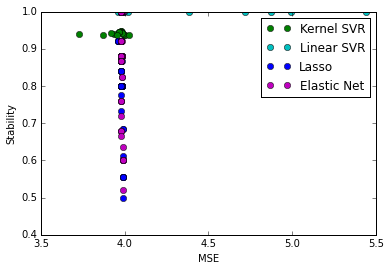

In [115]:
# plt.plot(kr_accuracy, kernel_ridge_stability, 'ro', 
#          label="Kernel Ridge")
plt.plot(svr_accuracy, svr_stability, 'go', 
         label="Kernel SVR")
plt.plot(linear_svr_accuracy, linear_svr_stability, 'co', 
         label="Linear SVR")
plt.plot(lasso_accuracy, lasso_stability, 'bo', 
         label="Lasso")
# plt.plot(lars_accuracy, lars_stability, 'yo', 
#          label="Lars")
plt.plot(enet_accuracy, enet_stability, 'mo', 
         label="Elastic Net")
# plt.plot(ridge_accuracy, ridge_stability, 'co', 
#          label="Ridge")

plt.xlabel("MSE")
plt.ylabel("Stability")
plt.legend(loc="best")
plt.savefig("acc_stability.eps", format="eps")
plt.show()

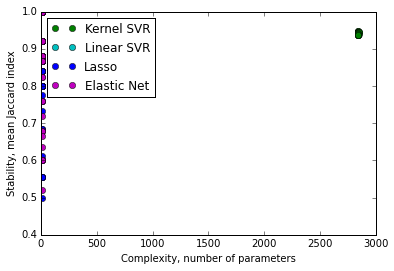

In [116]:
plt.plot(svr_complexity, svr_stability, 'go', 
         label="Kernel SVR")
plt.plot(linear_svr_complexity, linear_svr_stability, 'co', 
         label="Linear SVR")
plt.plot(lasso_complexity, lasso_stability, 'bo', 
         label="Lasso")
plt.plot(enet_complexity, enet_stability, 'mo', 
         label="Elastic Net")
plt.xlabel("Complexity, number of parameters")
plt.ylabel("Stability, mean Jaccard index")
plt.legend(loc="best")
plt.savefig("complexity_stability_jac.eps", format="eps")
plt.show()

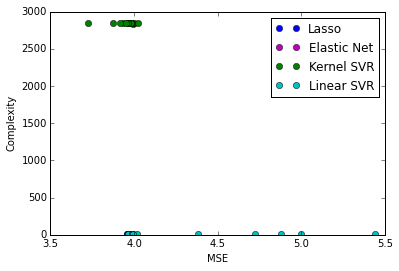

In [117]:
plt.figure()
plt.plot(lasso_accuracy, lasso_complexity, 'bo', 
         label="Lasso")
plt.plot(enet_accuracy, enet_complexity, 'mo', 
         label="Elastic Net")
plt.plot(svr_accuracy, svr_complexity, 'go', 
         label="Kernel SVR")
plt.plot(linear_svr_accuracy, linear_svr_complexity, 'co', 
         label="Linear SVR")
plt.xlabel("MSE")
plt.ylabel("Complexity")
plt.legend(loc="best")
plt.savefig("acc_complexity.eps", format="eps")
plt.show()